In [378]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [379]:
titanic_data=pd.read_csv('dataTitanic.csv')

In [380]:
# titanic_data
# titanic_data.describe()
# titanic_data.head()
# titanic_data.info()

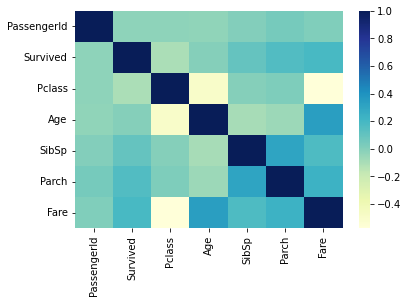

In [381]:
sns.heatmap(titanic_data.corr(),cmap="YlGnBu")
plt.show()

In [382]:
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2)
for train_indices, test_indices in split.split(titanic_data,titanic_data[["Survived","Pclass","Sex"]]):
        strat_train_set = titanic_data.loc[train_indices]
        strat_test_set = titanic_data.loc[test_indices]

In [383]:
# strat_test_set
# strat_train_set

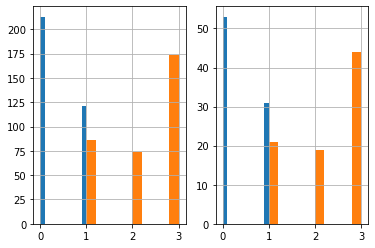

In [384]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()
plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()
plt.show() 
#equal distribution plots similar

In [385]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 395 to 264
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  334 non-null    int64  
 1   Survived     334 non-null    int64  
 2   Pclass       334 non-null    int64  
 3   Name         334 non-null    object 
 4   Sex          334 non-null    object 
 5   Age          269 non-null    float64
 6   SibSp        334 non-null    int64  
 7   Parch        334 non-null    int64  
 8   Ticket       334 non-null    object 
 9   Fare         333 non-null    float64
 10  Cabin        71 non-null     object 
 11  Embarked     334 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 33.9+ KB


In [386]:
class AgeImputer(BaseEstimator,TransformerMixin):
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        imputer=SimpleImputer(strategy="mean")
        X['Age']=imputer.fit_transform(X[['Age']])
        return X

In [387]:
class FeatureEncoder(BaseEstimator,TransformerMixin):
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        encoder=OneHotEncoder()
        
        matrix=encoder.fit_transform(X[['Embarked']]).toarray()
        column_names=["C","S","Q","N"]
        for i in range(len(matrix.T)):
            X[column_names[i]]=matrix.T[i]
        
        matrix=encoder.fit_transform(X[['Sex']]).toarray()
        column_names=["Female","Male"]
        for i in range(len(matrix.T)):
            X[column_names[i]]=matrix.T[i]
            
        return X

In [396]:
class FeatureNan(BaseEstimator,TransformerMixin):
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X['Fare']=X['Fare'].fillna(X['Fare'].mean())
        return X

In [389]:
class FeatureDropper(BaseEstimator,TransformerMixin):
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        return X.drop(["Embarked","Name","Ticket","Cabin","Sex","N"],axis=1,errors="ignore")

In [413]:
pipeline=Pipeline([("ageimputer",AgeImputer()),
                   ("featureencoder",FeatureEncoder()),
                   ("featurenan",FeatureNan()),
                   ("featuredropper",FeatureDropper())])
pipelineSet=pipeline.fit_transform(strat_train_set)

In [414]:
strat_train_set=pipelineSet

In [415]:
# strat_train_set

strat_train_set.info()
strat_train_set.to_excel("test.xlsx", index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 395 to 264
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  334 non-null    int64  
 1   Survived     334 non-null    int64  
 2   Pclass       334 non-null    int64  
 3   Age          334 non-null    float64
 4   SibSp        334 non-null    int64  
 5   Parch        334 non-null    int64  
 6   Fare         334 non-null    float64
 7   C            334 non-null    float64
 8   S            334 non-null    float64
 9   Q            334 non-null    float64
 10  Female       334 non-null    float64
 11  Male         334 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 33.9 KB


In [416]:
X=strat_train_set.drop(['Survived'],axis=1)
y=strat_train_set['Survived']
scaler=StandardScaler()
X_data =scaler.fit_transform(X)
y_data = y.to_numpy()

In [361]:
# X_data

In [362]:
# y_data

In [1]:
clf=RandomForestClassifier()
param_grid = [
    {"n_estimators":[10,100,200,500],
    "max_depth": [None,5,10],
     "min_samples_split": [2,3,4]
    }
]

grid_search=GridSearchCV(clf,param_grid,cv=3,scoring="accuracy",return_train_score=True)
grid_search.fit(X_data,y_data)

NameError: name 'RandomForestClassifier' is not defined

In [418]:
final_clf=grid_search.best_estimator_
final_clf

RandomForestClassifier(n_estimators=10)

In [420]:
pipelineTest=pipeline.fit_transform(strat_test_set)

In [421]:
strat_test_set=pipelineTest

In [422]:
X_test=strat_test_set.drop(['Survived'],axis=1)
y_test=strat_test_set['Survived']
scaler=StandardScaler()
X_data_test =scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [427]:
final_clf.score(X_data_test,y_data_test)

1.0

In [428]:
final_data=pipeline.fit_transform(titanic_data)

In [432]:
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,892,0,3,34.50000,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,1,3,47.00000,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,0,2,62.00000,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,0,3,27.00000,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,1,3,22.00000,1,1,12.2875,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
414,1306,1,1,39.00000,0,0,108.9000,1.0,0.0,0.0,1.0,0.0
415,1307,0,3,38.50000,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
416,1308,0,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [433]:
X_final=final_data.drop(["Survived"],axis=1)
y_final=final_data["Survived"]
scaler=StandardScaler()
X_data_final=scaler.fit_transform(X_final)
y_data_final=y_final.to_numpy()

In [434]:
clf=RandomForestClassifier()
param_grid = [
    {"n_estimators":[10,100,200,500],
    "max_depth": [None,5,10],
     "min_samples_split": [2,3,4]
    }
]

grid_search=GridSearchCV(clf,param_grid,cv=3,scoring="accuracy",return_train_score=True)
grid_search.fit(X_data_final,y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [435]:
prod_final_clf=grid_search.best_estimator_
prod_final_clf

RandomForestClassifier(n_estimators=10)